## 外部依赖及参数设置

### 导入外部依赖

In [1]:
import inspect
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
import os
import json
import logging
# from pathlib import Path
# 设置随机种子，保证结果可重现
# import random
# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)

### 编程环境搭建

In [2]:
train_model = False # 训练模式开关

from env import ElectromagneticDamperEnv # 自定义环境
from ddpg_agent import DDPGAgent, ReplayBuffer # DDPG智能体和经验回放缓冲区
from train import train_ddpg # 训练函数
from af import plot_rewards, plot_state_comparison, plot_data, plot_test_data # 绘图函数
from af import load_checkpoint # 加载检查点函数
from rewardfx import select_dimensions

# 设置中文字体
plt.rcParams['font.family'] = ['SimHei', 'Arial']

# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 创建保存模型的基础目录
base_dir = "./gru_savedata"
os.makedirs(base_dir, exist_ok=True)

# 确认训练保存目录
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")

project_name = input("请输入加载/创建项目的名称 (父目录: ./savedata) ").strip()

save_dir = os.path.join(base_dir, project_name)
is_new_project = not os.path.exists(save_dir)
os.makedirs(save_dir, exist_ok=True)
save_checkpoint_path = os.path.join(save_dir, "checkpoints")
os.makedirs(save_checkpoint_path, exist_ok=True)
save_plot_path = os.path.join(save_dir, "plots")
os.makedirs(save_plot_path, exist_ok=True)

# 创建日志文件
if not is_new_project:
    assign_log = input("是否指定日志文件？(路径/n) ").strip().lower()
    if assign_log == 'n' or assign_log == '':
        file_path = save_dir + f'\\training_log_{current_time}.log'
    else:
        file_path = assign_log
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))
else:
    file_path = save_dir + f'\\training_log_{current_time}.log'

logging.basicConfig(filename=file_path,  # 如果指定日志文件，则使用指定路径，否则不写入文件
                level=logging.INFO,          # 设置日志级别
                format='%(asctime)s - %(levelname)s - %(message)s')  # 设置日志格式
logging.info("## 当前时间: %s", datetime.now())
logging.info("项目保存目录: %s", save_dir)
logging.info("日志文件: %s", file_path)
logging.info("训练模式: %s", train_model)
logging.info("模型保存目录: %s", save_checkpoint_path)
logging.info("绘图保存目录: %s", save_plot_path)
logging.info("使用设备: %s", device)

使用设备: cuda


### 超参数设置

In [3]:
# 仿真环境设置
T = 10
Ts = 0.01
tolerance = 1e-4 # 误差容忍度
all_state0 = np.array([0.0, 0.0, 0.0, 0, 0.01, 0.0]) # 初始状态
x1_limit = 0.001
# DDPG智能体设置
hidden_dim=64 # 隐藏层维度
action_bound=5 # 动作范围
actor_lr=5e-4 # Actor学习率
critic_lr=1e-3 # Critic学习率
gamma=0.98 # 折扣因子
tau=5e-3 # 软更新参数
sigma=0.1 # 初始噪声标准差
clip_grad=True # 是否裁剪梯度
# 经验池设置
capacity= int(1e6) # 经验池容量
batch_size=128 # 批量大小
# 训练超参数
rand_prob = 0.05 # 随机动作概率
n_episodes = 400 # 训练轮数
min_buffer_size = int(5e3) # 最小经验池大小
print_interval = 5 # 打印间隔
save_interval = 5 # 保存间隔

# 观测状态列表
# 0: 吸振器位移 (x1)
# 1: 吸振器速度 (v1)
# 2: 吸振器加速度 (a1)
# 3: 平台位移 (x2)
# 4: 平台速度 (v2)
# 5: 平台加速度 (a2)

observation_indices = [0,2,3,5]  # 观测状态索引

### GRU-DDPG超参数设置

In [4]:
# GRU-DDPG特有参数
sequence_length = 10  # 序列长度
gru_hidden_dim = 64  # GRU隐藏维度
num_gru_layers = 1  # GRU层数
gru_dropout = 0.1  # GRU Dropout率

print(f"GRU序列长度: {sequence_length}")
print(f"GRU隐藏维度: {gru_hidden_dim}")
print(f"GRU层数: {num_gru_layers}")

GRU序列长度: 10
GRU隐藏维度: 64
GRU层数: 1


### 系统参数设置

从MATLAB仿真文件中提取二自由度电磁阻尼器系统的参数。

In [5]:
# 系统参数（来自MATLAB文件）
m = 1.6    # 电磁吸振器质量
M = 100.0  # 待减振对象质量
k_m = 3000  # 电磁吸振器刚度
k_M = 20000.0  # 平台刚度
k_f = 45.0  # 电—力常数 N/A
k_E = 0.0  # 作动器反电动势系数
L = 0.0045  # 线圈的电感
R_m = 5.0  # 线圈的电阻
c_m = 1.0  # 电磁吸振器阻尼
c_M = 5.0  # 平台阻尼

# 状态空间矩阵（来自MATLAB文件）
A = np.array([
    [0.0,    1.0,       0.0,         0.0],
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [0.0,    0.0,       0.0,         1.0],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

B = np.array([[0.0], [k_f/m], [0.0], [-k_f/M]])

C = np.array([
    [-k_m/m, -c_m/m,    k_m/m,       c_m/m],
    [k_m/M,  c_m/M,     -(k_m+k_M)/M, -(c_m+c_M)/M]
])

D = np.array([[+k_f/m], [-k_f/M]])

E = np.array([
    [0.0, 0.0, 0.0, c_M/M],
    [0.0, 0.0, 0.0, k_M/M]
]).T

## GRU-DDPG训练

本节实现基于GRU的DDPG算法，用于处理时序控制问题。GRU网络能够捕获状态的时序依赖性，提升控制性能。

### 初始化GRU-DDPG环境和代理

In [6]:
from ddpg_agent import GruDDPGAgent  # GRU-DDPG智能体

# 创建GRU-DDPG智能体
gru_agent = GruDDPGAgent(
    state_dim=len(observation_indices),  # 状态维度
    seq_len=sequence_length,  # 序列长度
    hidden_dim=gru_hidden_dim,  # 隐藏层维度
    num_layers=num_gru_layers,  # GRU层数
    action_bound=action_bound,  # 动作范围
    actor_lr=actor_lr,  # Actor学习率
    critic_lr=critic_lr,  # Critic学习率
    gamma=gamma,  # 折扣因子
    tau=tau,  # 软更新参数
    sigma=sigma,  # 初始噪声标准差
    clip_grad=clip_grad,  # 是否裁剪梯度
)

if train_model:
    from my_nn import Gru_ReplayBuffer  # GRU经验回放缓冲区
    # 创建GRU经验回放池
    gru_replay_buffer = Gru_ReplayBuffer(
        capacity=capacity, 
        batch_size=batch_size, 
        seq_len=sequence_length
    )
    
    print(f"GRU Agent模型名称: {gru_agent.model_name}")
    print(f"GRU状态维度: {len(observation_indices)}")
    print(f"GRU序列长度: {sequence_length}")

d:\anaconda3\envs\DRL_env\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


### GRU训练记录日志

In [7]:
if train_model:
    logging.info(f"开始GRU训练的时间: {datetime.now()}")
    gru_paras_info = {
        "模型类型": "GRU-DDPG",
        "序列长度": sequence_length,
        "GRU隐藏维度": gru_hidden_dim,
        "GRU层数": num_gru_layers,
        "GRU Dropout率": gru_dropout,
        "仿真时间": T,
        "采样时间": Ts,
        "误差容忍度": tolerance,
        "初始状态": all_state0.tolist(),
        "吸振器与平台的相对位移限制": x1_limit,
        "动作范围": action_bound,
        "Actor学习率": actor_lr,
        "Critic学习率": critic_lr,
        "折扣因子": gamma,
        "软更新参数": tau,
        "是否梯度裁剪": clip_grad,
        "初始噪声标准差(比例)": sigma,
        "经验池容量": capacity,
        "批量大小": batch_size,
        "随机动作概率": rand_prob,
        "训练轮数": n_episodes,
        "最小经验池大小": min_buffer_size,
        "打印间隔": print_interval,
        "保存间隔": save_interval
    }
    logging.info(f"GRU训练参数：{json.dumps(gru_paras_info, indent=4, ensure_ascii=False)}")
    
    logging.info(f"GRU Actor网络架构:{gru_agent.actor}")
    logging.info(f"GRU Critic网络架构:{gru_agent.critic}")

### 定义环境、扰动、奖励函数

In [8]:
def zero_func(t):
    """零扰动函数"""
    return 0.0
z_func = zero_func

from rewardfx import tolerance_if_rf, tolerance_exp_rf, test_reward_function, better_reward_function, squared_reward_function
r_func = tolerance_if_rf(tolerance=tolerance)

if train_model: logging.info("正弦扰动函数已定义: %s", inspect.getsource(z_func))

if train_model: logging.info("奖励函数已定义: %s", inspect.getsource(r_func))
# 创建仿真环境
rl_env = ElectromagneticDamperEnv(A, B, C, D, E, Ts=Ts, T=T, 
                                  z_func=z_func, r_func=r_func,
                                  obs_indices=observation_indices,
                                  all_state0=all_state0.copy(),x1_limit=x1_limit)

### 训练GRU-DDPG代理

In [9]:

if train_model:
    # 创建GRU检查点保存目录
    gru_save_checkpoint_path = os.path.join(save_dir, "gru_checkpoints")
    os.makedirs(gru_save_checkpoint_path, exist_ok=True)
    
        # 加载GRU检查点
    gru_start_episode, gru_initial_episode_rewards = load_checkpoint(
        agent=gru_agent, 
        save_dir=save_dir
    )
    logging.info(f"GRU开始训练的轮数: {gru_start_episode}")
    
    from train import train_gru_ddpg  # GRU训练函数
    # 训练GRU-DDPG代理
    try:
        gru_training_results = train_gru_ddpg(
            env=rl_env,
            agent=gru_agent,
            replay_buffer=gru_replay_buffer,
            n_episodes=n_episodes,
            min_buffer_size=min_buffer_size,
            print_interval=print_interval,
            save_interval=save_interval,
            save_path=gru_save_checkpoint_path,
            start_episode=gru_start_episode,
            initial_episode_rewards=gru_initial_episode_rewards,
            rand_prob=rand_prob
        )
        logging.info(f"GRU训练完成，最终平均奖励: {gru_training_results['avg_rewards'][-1]:.2f}")
    except KeyboardInterrupt:
        logging.info("GRU训练中断，保存当前模型...")
        gru_agent.save_model(save_path=gru_save_checkpoint_path, episode=n_episodes)
        logging.info("GRU模型已保存。")
    except Exception as e:
        logging.error(f"GRU训练过程中发生错误: {e}")
        raise e

## GRU-DDPG测试与对比

本节对GRU-DDPG模型进行测试，并与传统DDPG进行性能对比。


找到以下检查点文件:
1. gru_0609_1755_ep245_checkpoint.pth
2. gru_0609_1755_ep240_checkpoint.pth
3. gru_0609_1755_ep235_checkpoint.pth
4. gru_0609_1755_ep230_checkpoint.pth
5. gru_0609_1755_ep225_checkpoint.pth
6. gru_0609_1755_ep220_checkpoint.pth
7. gru_0609_1755_ep215_checkpoint.pth
8. gru_0609_1755_ep210_checkpoint.pth
9. gru_0609_1755_ep205_checkpoint.pth
10. gru_0609_1755_ep200_checkpoint.pth
11. gru_0609_1755_ep195_checkpoint.pth
12. gru_0609_1755_ep190_checkpoint.pth
13. gru_0609_1755_ep185_checkpoint.pth
14. gru_0609_1755_ep180_checkpoint.pth
15. gru_0609_1755_ep175_checkpoint.pth
16. gru_0609_1755_ep170_checkpoint.pth
17. gru_0609_1755_ep165_checkpoint.pth
18. gru_0609_1755_ep160_checkpoint.pth
19. gru_0609_1755_ep155_checkpoint.pth
20. gru_0609_1755_ep150_checkpoint.pth
21. gru_0609_1755_ep145_checkpoint.pth
22. gru_0609_1755_ep140_checkpoint.pth
23. gru_0609_1755_ep135_checkpoint.pth
24. gru_0609_1755_ep130_checkpoint.pth
25. gru_0609_1755_ep125_checkpoint.pth
26. gru_0609_1755_ep12

e:\学习\专题学习\DySysIdCtrl\电磁式阻尼器深度强化学习\ddpg_agent.py:352: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


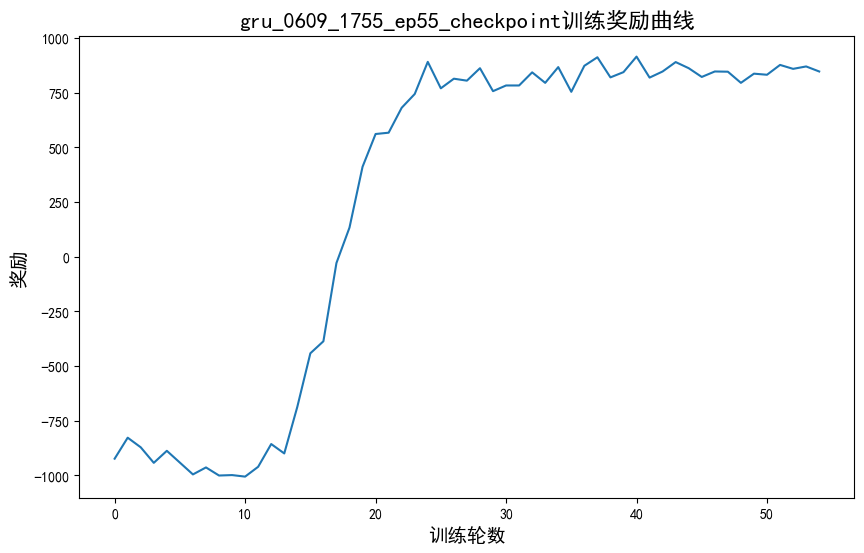

In [10]:
# 如果不是训练模式，则加载已保存的GRU模型
if train_model is not True:
    # 加载GRU检查点
    gru_save_checkpoint_path = os.path.join(save_dir, "gru_checkpoints")
    _, gru_episode_rewards = load_checkpoint(agent=gru_agent, save_dir=gru_save_checkpoint_path)
else:
    gru_episode_rewards = gru_training_results['episode_rewards']
    gru_avg_rewards = gru_training_results['avg_rewards']

# 绘制GRU训练奖励曲线
plot_data(plot_title=f"{gru_agent.model_name}训练奖励曲线",
          xlabel="训练轮数",
          ylabel="奖励",
          data_sets=[gru_episode_rewards],
          save_path=save_plot_path)

logging.info(f"GRU奖励图表已保存: {save_plot_path}")

仿真进度: 1001it [00:00, 15730.02it/s]            
仿真进度: 1001it [00:01, 760.71it/s]                         


GRU-DDPG总奖励: 890.5


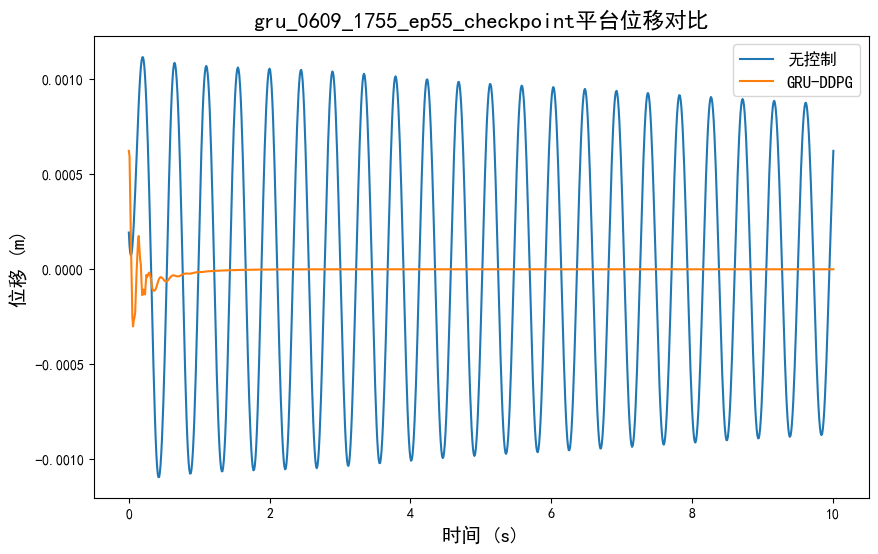

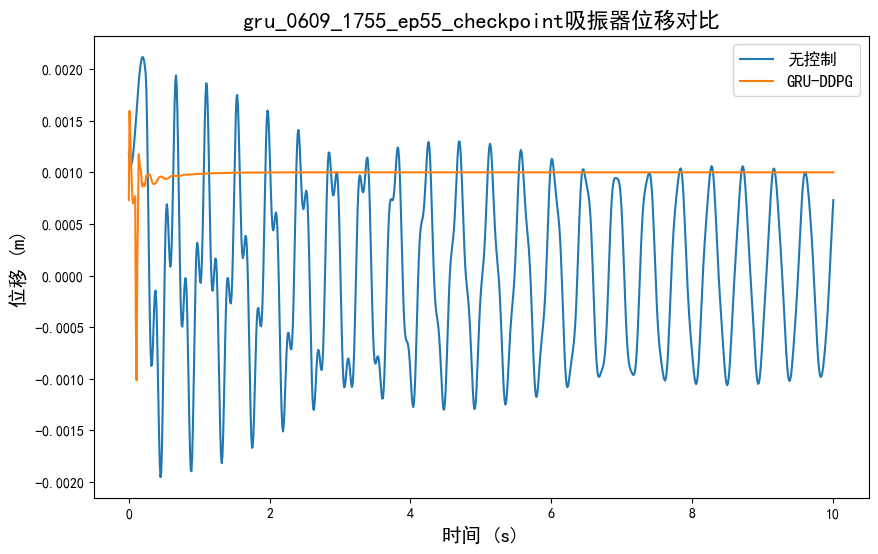

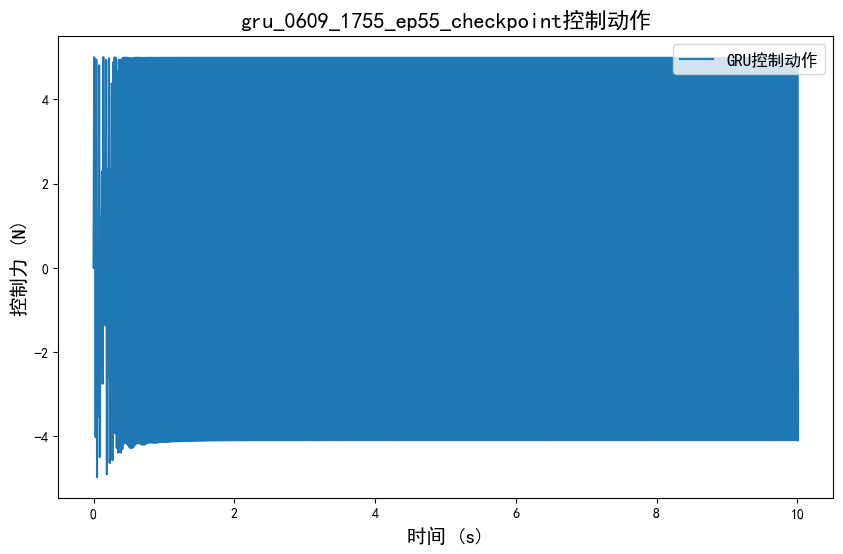

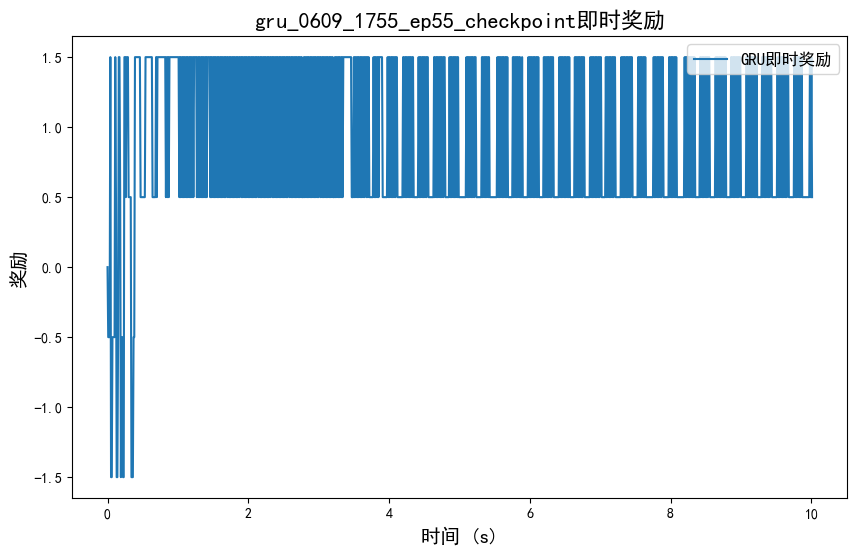

In [12]:
# 测试GRU-DDPG模型性能
rl_env.Ts = 0.01  # 设置仿真采样时间

def sine_disturbance(amp, freq):
    """正弦扰动函数"""
    def func(t):
        return amp * np.sin(freq * t)
    return func

# 运行GRU-DDPG控制仿真
results_nc = rl_env.run_simulation(z_func=sine_disturbance(0.001, 300), r_func=r_func)
results_gru_ddpg = rl_env.run_simulation(controller=gru_agent)
print(f"GRU-DDPG总奖励: {np.sum(results_gru_ddpg['rewards'])}")


plot_data(plot_title=f"{gru_agent.model_name}平台位移对比",
            xlabel="时间 (s)",
            ylabel="位移 (m)",
            x_values=results_gru_ddpg['times'],
            data_sets=[
                results_nc['all_states'][:, 3],
                results_gru_ddpg['all_states'][:, 3]
            ],
            save_path=save_plot_path,
            legends=["无控制", "GRU-DDPG"]
            )

plot_data(plot_title=f"{gru_agent.model_name}吸振器位移对比",
            xlabel="时间 (s)",
            ylabel="位移 (m)",
            x_values=results_gru_ddpg['times'],
            data_sets=[
                results_nc['all_states'][:, 0],
                results_gru_ddpg['all_states'][:, 0]
            ],
            save_path=save_plot_path,
            legends=["无控制", "GRU-DDPG"]
            )

# 绘制GRU-DDPG独有的图表
plot_data(plot_title=f"{gru_agent.model_name}控制动作",
          xlabel="时间 (s)",
          ylabel="控制力 (N)",
          x_values=results_gru_ddpg['times'],
          data_sets=[results_gru_ddpg['actions']],
          save_path=save_plot_path,
          legends=["GRU控制动作"]
          )

plot_data(plot_title=f"{gru_agent.model_name}即时奖励",
          xlabel="时间 (s)",
          ylabel="奖励",
          x_values=results_gru_ddpg['times'],
          data_sets=[results_gru_ddpg['rewards']],
          save_path=save_plot_path,
          legends=["GRU即时奖励"]
          )